In [1]:
import torch
from sentence_transformers import SentenceTransformer

from score_models.models.unet.unet import CondUNet
from score_models.sampling import ddpm_sampling
from score_models.utils.noise import get_betas
from score_models.utils.visualisations import show_torch_images

%load_ext autoreload
%autoreload 2


/home/robert/anaconda3/envs/score-models/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
T=1_000
in_ch = 3
ch = 128
ch_mult = [1, 2, 3, 4]
cond_ch = 768
attn = [2]
num_res_blocks = 2
dropout = 0.15
device = "cuda"
compile = True

# construct score model
score_model = CondUNet(
    T=T, 
    in_ch=in_ch, 
    ch=ch, 
    ch_mult=ch_mult, 
    cond_ch=cond_ch,
    attn=attn, 
    num_res_blocks=num_res_blocks, 
    dropout=dropout,
).to(device)

# compile model
if compile:
    score_model = torch.compile(score_model)

# load pre-trained model
path = "../scripts/checkpoints/ddpm_nouns/150000.pt"
score_model.load_state_dict(
    torch.load(path)["model_state_dict"]
)

# define train step (i.e., criterion)
beta_min, beta_max = 1e-4, 2e-2
betas = get_betas(beta_min=beta_min, beta_max=beta_max, T=T)

In [55]:
# load sentence encoder
cond_model = SentenceTransformer("all-mpnet-base-v2")
cond_model = cond_model.to(device)

# text
# text = 4 * ["a pixel art character with square yellow glasses, a shoe-shaped head and a darkbrown-colored body on a warm background"]
text = [
    "a pixel art character with square red glasses, a monkey-shaped head and a grayscale-colored body on a warm background",
    "a pixel art character with square yellow glasses, a kangaroo-shaped head and a magenta-colored body on a warm background",
    "a pixel art character with square blue glasses, a grouper-shaped head and a blue-colored body on a warm background",
    "a pixel art character with square black glasses, a mushroom-shaped head and a peachy-colored body on a warm background",
]

y = cond_model.encode(text, convert_to_tensor=True).unsqueeze(1).to(device)

In [66]:
history_buffer = []
x = torch.randn(4, 3, 32, 32).to(device)
samples = ddpm_sampling(
    x=x,
    y=y,
    score_model=score_model,
    alphas=betas["alphas"],
    alphas_bar=betas["alphas_bar"],
    sigmas=betas["sigmas"],
    history_buffer=history_buffer,
).cpu()

samples = torch.clamp(samples, -1, 1)
samples = (samples + 1) / 2
samples = list(samples)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:12<00:00, 77.20it/s]


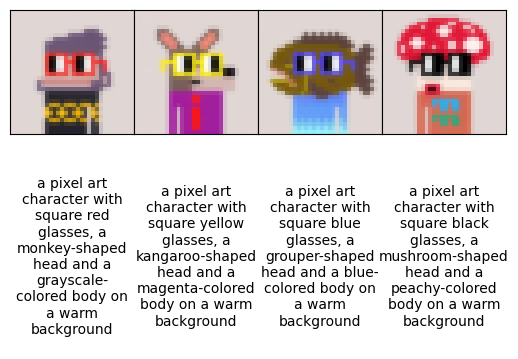

In [67]:
show_torch_images(samples, text)